참고
https://catboost.ai/en/docs/concepts/python-reference_catboostregressor

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [128]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import tqdm
import pdb
from scipy.sparse import csr_matrix, linalg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder # id2idx에 필요
from sklearn.metrics import mean_squared_error, r2_score

import random
random.seed(42)
import os
import re


from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

from sklearn.metrics import mean_absolute_error

warnings.filterwarnings(action='ignore')

In [129]:
path= 'data/'    # feat siyun - 디렉토리 해당 파일에 맞게 변경 필요

users = pd.read_csv(path+'users.csv')
books = pd.read_csv(path+'books.csv')
train_ratings = pd.read_csv(path+'train_ratings.csv')
test_ratings = pd.read_csv(path+'test_ratings.csv')
submit = pd.read_csv(path + 'sample_submission.csv')


def rmse(real: list, predict: list) -> float:
    pred = np.array(predict)
    return np.sqrt(np.mean((real-pred) ** 2))


#  보통 seed는 42로 설정
import random
random.seed(42)

print('users shape: ', users.shape)
print('books shape: ', books.shape)
print('train_ratings shape: ', train_ratings.shape)

users shape:  (68092, 3)
books shape:  (149570, 10)
train_ratings shape:  (306795, 3)


# 데이터 전처리

## books

In [130]:
books.head()

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
0,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,['Actresses'],"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg
1,0060973129,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,en,['1940-1949'],"Here, for the first time in paperback, is an o...",images/0060973129.01.THUMBZZZ.jpg
2,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,en,['Medical'],"Describes the great flu epidemic of 1918, an o...",images/0374157065.01.THUMBZZZ.jpg
3,0399135782,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,en,['Fiction'],A Chinese immigrant who is convinced she is dy...,images/0399135782.01.THUMBZZZ.jpg
4,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000.0,Berkley Publishing Group,http://images.amazon.com/images/P/0425176428.0...,en,['History'],"Essays by respected military historians, inclu...",images/0425176428.01.THUMBZZZ.jpg


In [131]:
# 멘토님의 조언에 따라 비정형 데이터 제거
books.drop(['summary', 'img_path', 'img_url'], axis = 1, inplace = True)

In [132]:
books.columns

Index(['isbn', 'book_title', 'book_author', 'year_of_publication', 'publisher',
       'language', 'category'],
      dtype='object')

## isbn language 처리

In [77]:
# # !pip install isbnlib
# import isbnlib
# from tqdm import tqdm


# # isbn '-' 으로 구분해 새롭게 만든 'mask_isbn' 컬럼에 넣기
# books['mask_isbn'] = np.nan
# for i in tqdm(range(books.shape[0])):
#   try:
#     books.loc[i, 'mask_isbn'] = isbnlib.mask(books['isbn'][i])
#   except:
#     pass


# # '-'로 구분한 값 중 첫 번째, 'group' 속성 추출해 새롭게 만든 'lang_isbn' 컬럼에 넣기
# books['lang_isbn'] = np.nan
# for i in tqdm(range(books.shape[0])):
#   try:
#     books.loc[i, 'lang_isbn'] = books['mask_isbn'][i].split('-')[0]
#   except:
#     pass


# # lang_isbn 값 유 & language 무 => lang_isbn 값 유 & language 유 를 value_counts() 하여 가장 많은 값 넣기
# lang_null = books.loc[books['language'].isna()]['lang_isbn'].unique()
# for i in lang_null:
#   try:
#     candidate_lang = books.loc[books['lang_isbn']==i]['language'].value_counts().index[0]
#     books.loc[books[(books['lang_isbn']==i)&(books['language'].isna())].index, 'language'] = candidate_lang
#   except:
#     pass


# # null 값 etc로 채우기
# books['language'].fillna('etc', inplace = True)

100%|██████████| 149570/149570 [00:13<00:00, 10999.07it/s]


In [81]:
books

,isbn,book_title,book_author,year_of_publication,publisher,language,category,mask_isbn,lang_isbn
0,0002005018,ClaraCallan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,en,['Actresses'],0-00-200501-8,0
1,0060973129,DecisioninNormandy,Carlo D'Este,1991.0,HarperPerennial,en,['1940-1949'],0-06-097312-9,0
2,0374157065,Flu:TheStoryoftheGreatInfluenzaPandemicof1918a...,Gina Bari Kolata,1999.0,Farrar Straus Giroux,en,['Medical'],0-374-15706-5,0
3,0399135782,TheKitchenGod'sWife,Amy Tan,1991.0,Putnam Pub Group,en,['Fiction'],0-399-13578-2,0
4,0425176428,WhatIf?:TheWorld'sForemostMilitaryHistoriansIm...,Robert Cowley,2000.0,Berkley Publishing Group,en,['History'],0-425-17642-8,0
...,...,...,...,...,...,...,...,...,...
149565,067161746X,TheBachelorHomeCompanion:APracticalGuidetoKeep...,P.J. O'Rourke,1987.0,Pocket Books,en,['Humor'],0-671-61746-X,0
149566,0767907566,AllElevationsUnknown:AnAdventureintheHeartofBo...,Sam Lightner,2001.0,Broadway Books,en,['Nature'],0-7679-0756-6,0
149567,0884159221,Whystop?:AguidetoTexashistoricalroadsidemarkers,Claude Dooley,1985.0,Lone Star Books,en,NaN,0-88415-922-1,0
149568,0912333022,TheAreYouBeingServed?Stories:'CampingIn'andOth...,Jeremy Lloyd,1997.0,Kqed Books,en,['Fiction'],0-912333-02-2,0


In [79]:
books.language.isna().sum()

0

In [133]:
books['book_title']= books['book_title'].apply(lambda x: ''.join(x.split()).strip())
books['book_title']

0                                               ClaraCallan
1                                        DecisioninNormandy
2         Flu:TheStoryoftheGreatInfluenzaPandemicof1918a...
3                                       TheKitchenGod'sWife
4         WhatIf?:TheWorld'sForemostMilitaryHistoriansIm...
                                ...                        
149565    TheBachelorHomeCompanion:APracticalGuidetoKeep...
149566    AllElevationsUnknown:AnAdventureintheHeartofBo...
149567      Whystop?:AguidetoTexashistoricalroadsidemarkers
149568    TheAreYouBeingServed?Stories:'CampingIn'andOth...
149569         DallasStreetMapGuideandDirectory,2000Edition
Name: book_title, Length: 149570, dtype: object

In [134]:
# books의 카테고리 부분. 베이스라인 코드 참고

# 대괄호 써있는 카테고리 전처리
books.loc[books[books['category'].notnull()].index, 'category'] = books[books['category'].notnull()]['category'].apply(lambda x: re.sub('[\W_]+',' ',x).strip())
# 모두 소문자로 통일
books['category'] = books['category'].str.lower()

# 미리 지정해놓은 category에 맞춰 category_high 칼럼 추가

categories_50 = [
        'Fiction', 'Science Fiction', 'Fantasy', 'Science', 'History', 'Autobiography', 'Mystery', 'Thriller', 'Romance', 'Politics',
        'Economics', 'Psychology', 'Philosophy', 'Religion', 'Sociology', 'Culture', 'Art', 'Music', 'Engineering', 'Computer Science',
        'Mathematics', 'Biology', 'Physics', 'Chemistry', 'Medicine', 'Family and Relationships', 'Cooking', 'Travel', 'Sports', 'Health and Wellness',
        'Nature', 'Environment', 'Animals', 'Plants', 'Technology', 'Business', 'Self-Help', 'Personal Growth', "Children's Books", 'Comics',
        'Young Adult', "Children's Picture Books", 'Science Books', 'Art and Photography', 'Poetry', 'Drama', 'Literary Fiction', 'Architecture',
        ]

books['category_high'] = books['category'].copy()
for category in categories_50:
    books.loc[books[books['category'].str.contains(category,na=False)].index,'category_high'] = category

In [135]:
# 추가로 항목이 5개 이하인 것은 others로 분류
category_counts = books['category_high'].value_counts()
categories_to_others = category_counts[category_counts <= 10].index
books.loc[books['category_high'].isin(categories_to_others), 'category_high'] = 'others'

In [136]:
books['category_high'].value_counts()

category_high
fiction                      33016
others                        7178
juvenile fiction              5835
biography autobiography       3326
history                       1927
                             ...  
discworld imaginary place       11
readers                         11
russia                          11
authors french                  11
electronic books                11
Name: count, Length: 238, dtype: int64

In [ ]:
# def fill_pub_info(books) :
#     '''
#     isbn lib를 활용하여 출판사의 정보를 불러와 결측값을 채웁니다.
#     사용할 수 없으면 가장 대중적인 언어로 처리하는 방식을 사용합니다.
#     '''
#     def getlang(isbn) :
#         try :
#             book_info = isbnlib.meta(isbn)
#             # print(book_info)
#             language = book_info.get('Language', np.nan)
#         except :
#             # print('error')
#             language = np.nan
#         return language

#     books['language'] = books['isbn'].apply(getlang)

#     return books

In [137]:
# 대부분의 country는 미국이기 때문에 결측치를 영어로 처리, category_high의 결측치는 fiction으로 처리
books['language'].fillna('en', inplace = True)
books['category_high'].fillna('fiction', inplace=True)
books['book_author'].fillna('other', inplace=True)

In [138]:
books.head()

,isbn,book_title,book_author,year_of_publication,publisher,language,category,category_high
0,0002005018,ClaraCallan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,en,actresses,actresses
1,0060973129,DecisioninNormandy,Carlo D'Este,1991.0,HarperPerennial,en,1940 1949,others
2,0374157065,Flu:TheStoryoftheGreatInfluenzaPandemicof1918a...,Gina Bari Kolata,1999.0,Farrar Straus Giroux,en,medical,medical
3,0399135782,TheKitchenGod'sWife,Amy Tan,1991.0,Putnam Pub Group,en,fiction,fiction
4,0425176428,WhatIf?:TheWorld'sForemostMilitaryHistoriansIm...,Robert Cowley,2000.0,Berkley Publishing Group,en,history,history


In [139]:
books.category_high.value_counts()

category_high
fiction                      101867
others                         7178
juvenile fiction               5835
biography autobiography        3326
history                        1927
                              ...  
discworld imaginary place        11
readers                          11
russia                           11
authors french                   11
electronic books                 11
Name: count, Length: 238, dtype: int64

In [88]:
books.isna().sum()

isbn                       0
book_title                 0
book_author                0
year_of_publication        0
publisher                  0
language                   0
category               68851
mask_isbn                 47
lang_isbn                 47
category_high              0
dtype: int64

In [140]:
# 출판연도 범주화
# catboost 모델의 성능을 더 올리기 위해 데이터를 categorize

books['years'] = books['year_of_publication'].copy()
books['years'][books['year_of_publication'] < 1970] = 1970
books['years'][(books['year_of_publication'] < 1980) * (books['year_of_publication'] >= 1970)] = 1980
books['years'][(books['year_of_publication'] < 1990) * (books['year_of_publication'] >= 1980)] = 1990
books['years'][(books['year_of_publication'] < 2000) * (books['year_of_publication'] >= 1990)] = 2000
books['years'][(books['year_of_publication'] >= 2000)] = 2020
books['years'] = books['years'].astype('str')
#books['years'] = books['years'].astype('int')
books.drop(['year_of_publication', 'category'], axis = 1, inplace = True)

books.to_csv('../data/books.csv', index = False)

In [141]:
books.isna().sum()

isbn             0
book_title       0
book_author      0
publisher        0
language         0
category_high    0
years            0
dtype: int64

## users

In [142]:
users.head()

,user_id,location,age
0,8,"timmins, ontario, canada",NaN
1,11400,"ottawa, ontario, canada",49.0
2,11676,"n/a, n/a, n/a",NaN
3,67544,"toronto, ontario, canada",30.0
4,85526,"victoria, british columbia, canada",36.0


age 처리

In [143]:
users['age'].fillna(np.mean(users['age']), inplace=True)

In [144]:
users['age']

0        36.069873
1        49.000000
2        36.069873
3        30.000000
4        36.000000
           ...    
68087    54.000000
68088    74.000000
68089    36.069873
68090    33.000000
68091    63.000000
Name: age, Length: 68092, dtype: float64

In [145]:
# baseline에 나온 그대로 진행
# 그대로 진행하는 것이 더 좋은 결과를 예측할 것.

def age_map(x):
    x = int(x)
    if x < 20:
        return 1
    elif x >= 20 and x < 30:
        return 2
    elif x >= 30 and x < 40:
        return 3
    elif x >= 40 and x < 50:
        return 4
    elif x >= 50 and x < 60:
        return 5
    else:
        return 6
    
users['age'] = users['age'].apply(age_map)

In [146]:
users.head()

,user_id,location,age
0,8,"timmins, ontario, canada",3
1,11400,"ottawa, ontario, canada",4
2,11676,"n/a, n/a, n/a",3
3,67544,"toronto, ontario, canada",3
4,85526,"victoria, british columbia, canada",3


In [147]:
users['age'].unique()

array([3, 4, 2, 6, 5, 1])

In [148]:
users['location'] = users['location'].str.replace(r'[^0-9a-zA-Z:,]', '') # 특수문자 제거

users['location_city'] = users['location'].apply(lambda x: x.split(',')[0].strip())
users['location_state'] = users['location'].apply(lambda x: x.split(',')[1].strip())
users['location_country'] = users['location'].apply(lambda x: x.split(',')[2].strip())

users = users.replace('na', np.nan) #특수문자 제거로 n/a가 na로 바뀌게 되었습니다. 따라서 이를 컴퓨터가 인식할 수 있는 결측값으로 변환합니다.
users = users.replace('', np.nan) # 일부 경우 , , ,으로 입력된 경우가 있었으므로 이런 경우에도 결측값으로 변환합니다.

In [110]:
users.head()

,user_id,location_city,location_state,location_country,age
0,8,0,0,0,3
1,11400,1,1,1,4
2,11676,2,2,2,3
3,67544,3,1,1,3
4,85526,4,3,0,3


In [149]:
# ffm_preprocessing 참고
# 원래는 지정해둔 cities로 하려고 했지만, 여기에서 처리하기에는 시간이 오래걸리는 것 같아 일단 default로 대체
modify_location = users[(users['location_country'].isna())&(users['location_city'].notnull())]['location_city'].values
location = users[(users['location'].str.contains('seattle'))&(users['location_country'].notnull())]['location'].value_counts().index[0]



# cities = [
#     'newyorkcity', 'losangeles', 'chicago', 'houston', 'phoenix',
#     'philadelphia', 'sanantonio', 'sandiego', 'dallas', 'sanjose',
#     'austin', 'jacksonville', 'sanfrancisco', 'columbus', 'fortworth',
#     'indianapolis', 'charlotte', 'seattle', 'denver', 'washington,d.c.',
#     'boston', 'elpaso', 'nashville', 'detroit', 'oklahomacity',
#     'portland', 'lasvegas', 'memphis', 'louisville', 'baltimore',
#     'milwaukee', 'albuquerque', 'tucson', 'fresno', 'sacramento',
#     'kansascity', 'longbeach', 'mesa', 'atlanta', 'coloradosprings',
#     'virginiabeach', 'raleigh', 'omaha', 'miami', 'oakland', 'minneapolis',
#     'tulsa', 'wichita', 'neworleans'
# ]



# 이렇게 하면 내부의 데이터를 사용하여 처리.
location_list = []
for location in modify_location:
    try:
        right_location = users[(users['location'].str.contains(location))&(users['location_country'].notnull())]['location'].value_counts().index[0]
        location_list.append(right_location)
    except:
        pass

for location in location_list:
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_state'] = location.split(',')[1]
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_country'] = location.split(',')[2]

# city, state, country 딕셔너리 생성
loc_city2idx = {v:k for k,v in enumerate(users['location_city'].unique())}
loc_state2idx = {v:k for k,v in enumerate(users['location_state'].unique())}
loc_country2idx = {v:k for k,v in enumerate(users['location_country'].unique())}

# 딕셔너리를 기준으로 매핑 진행
users['location_city'] = users['location_city'].map(loc_city2idx)
users['location_state'] = users['location_state'].map(loc_state2idx)
users['location_country'] = users['location_country'].map(loc_country2idx)

users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           68092 non-null  int64 
 1   location          68092 non-null  object
 2   age               68092 non-null  int64 
 3   location_city     68092 non-null  int64 
 4   location_state    68092 non-null  int64 
 5   location_country  68092 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 3.1+ MB


In [100]:
users.head()

,user_id,location,age,location_city,location_state,location_country
0,8,"timmins, ontario, canada",3,0,0,0
1,11400,"ottawa, ontario, canada",4,1,1,1
2,11676,"n/a, n/a, n/a",3,2,2,2
3,67544,"toronto, ontario, canada",3,3,1,1
4,85526,"victoria, british columbia, canada",3,4,3,0


In [150]:
users = users[['user_id', 'location_city', 'location_state', 'location_country','age']]
users.to_csv('../data/users.csv', index = False)

In [151]:
users = pd.read_csv(path+'users.csv')
books = pd.read_csv(path+'books.csv')

## merge(books, user, rating)

In [152]:
# 전처리 완료한 books와 users 테이블을 이용해 rating 테이블과 merge 하기.
# baseline참고
train_ratings = pd.read_csv(path+'train_ratings.csv')
test_ratings = pd.read_csv(path+'test_ratings.csv')

train_ratings = pd.merge(train_ratings,books, how='right',on='isbn')
train_ratings.dropna(subset=['rating'], inplace = True)
train_ratings = pd.merge(train_ratings, users, how='right',on='user_id')
train_ratings.dropna(subset=['rating'], inplace = True)

test_ratings['index'] = test_ratings.index
test_ratings = pd.merge(test_ratings,books, how='right',on='isbn')
test_ratings.dropna(subset=['rating'], inplace = True)
test_ratings = pd.merge(test_ratings, users, how='right',on='user_id')
test_ratings.dropna(subset=['rating'], inplace = True)
test_ratings = test_ratings.sort_values('index')
test_ratings.drop(['index'], axis=1, inplace=True)

train_ratings['user_id'] = train_ratings['user_id'].astype('str')
test_ratings['user_id'] = test_ratings['user_id'].astype('str')

train_ratings['location_city'] = train_ratings['location_city'].astype('str')
test_ratings['location_city'] = test_ratings['location_city'].astype('str')

train_ratings['location_state'] = train_ratings['location_state'].astype('str')
test_ratings['location_state'] = test_ratings['location_state'].astype('str')

train_ratings['location_country'] = train_ratings['location_country'].astype('str')
test_ratings['location_country'] = test_ratings['location_country'].astype('str')

train_ratings['rating'] = train_ratings['rating'].astype(int)
train_ratings['years'] = train_ratings['years'].astype(int)
train_ratings['age'] = train_ratings['age'].astype(int)

test_ratings['rating'] = test_ratings['rating'].astype(int)
test_ratings['years'] = test_ratings['years'].astype(int)
test_ratings['age'] = test_ratings['age'].astype(int)


In [113]:
train_ratings.drop(['mask_isbn','lang_isbn'],axis=1, inplace=True)

In [153]:
train_ratings.head()

,user_id,isbn,rating,book_title,book_author,publisher,language,category_high,years,location_city,location_state,location_country,age
0,8.0,0002005018,4,ClaraCallan,Richard Bruce Wright,HarperFlamingo Canada,en,actresses,2020,0,0,0,3
1,8.0,074322678X,4,WhereYou'llFindMe:AndOtherStories,Ann Beattie,Scribner,en,fiction,2020,0,0,0,3
2,8.0,0887841740,2,TheMiddleStories,Sheila Heti,House of Anansi Press,en,fiction,2020,0,0,0,3
3,8.0,1552041778,2,JaneDoe,R. J. Kaiser,Mira Books,en,fiction,2000,0,0,0,3
4,8.0,1567407781,6,TheWitchfinder(AmosWalkerMysterySeries),Loren D. Estleman,Brilliance Audio - Trade,en,fiction,2000,0,0,0,3


In [154]:
test_ratings.drop(['mask_isbn','lang_isbn'],axis=1, inplace=True)

test_ratings.head()

KeyError: "['mask_isbn', 'lang_isbn'] not found in axis"

In [155]:
print(train_ratings.location_city.unique())
print(train_ratings.location_state.unique())
print(train_ratings.location_country.unique())

['0' '1' '2' ... '12269' '12270' '7632']
['0' '1' '2' ... '1527' '1528' '1529']
['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '30' '31' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41' '42' '43'
 '44' '45' '46' '47' '48' '49' '50' '51' '52' '53' '55' '56' '57' '58'
 '59' '54' '60' '61' '62' '63' '64' '65' '66' '67' '69' '70' '71' '72'
 '73' '74' '75' '76' '77' '78' '79' '80' '82' '83' '84' '85' '86' '87'
 '88' '89' '90' '91' '92' '93' '94' '95' '97' '98' '100' '101' '102' '103'
 '104' '105' '106' '107' '108' '109' '110' '111' '112' '113' '114' '115'
 '116' '117' '118' '99' '120' '121' '122' '123' '124' '125' '126' '127'
 '128' '129' '130' '131' '132' '133' '135' '96' '136' '137' '138' '139'
 '141' '142' '144' '146' '147' '149' '150' '152' '148' '153' '154' '155'
 '156' '157' '158' '159' '160' '161' '162' '163' '164' '165' '166' '167'
 '168' '169' '170' '172' '173' '175' '176' '177' '180' '

In [156]:
train_ratings.isna().sum()

user_id             0
isbn                0
rating              0
book_title          0
book_author         0
publisher           0
language            0
category_high       0
years               0
location_city       0
location_state      0
location_country    0
age                 0
dtype: int64

In [157]:
train_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 306795 entries, 0 to 315083
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           306795 non-null  object
 1   isbn              306795 non-null  object
 2   rating            306795 non-null  int64 
 3   book_title        306795 non-null  object
 4   book_author       306795 non-null  object
 5   publisher         306795 non-null  object
 6   language          306795 non-null  object
 7   category_high     306795 non-null  object
 8   years             306795 non-null  int64 
 9   location_city     306795 non-null  object
 10  location_state    306795 non-null  object
 11  location_country  306795 non-null  object
 12  age               306795 non-null  int64 
dtypes: int64(3), object(10)
memory usage: 32.8+ MB


In [158]:
train_ratings = train_ratings.dropna()

In [160]:
train_ratings.isna().sum()

user_id             0
isbn                0
rating              0
book_title          0
book_author         0
publisher           0
language            0
category_high       0
years               0
location_city       0
location_state      0
location_country    0
age                 0
dtype: int64

In [161]:
test_ratings.isna().sum()

user_id             0
isbn                0
rating              0
book_title          0
book_author         0
publisher           0
language            0
category_high       0
years               0
location_city       0
location_state      0
location_country    0
age                 0
dtype: int64

# 모델링

### baseline

In [ ]:
"""
# baseline 모델 test
test_ratings['rating'] = pred
test = test_ratings[['user_id', 'isbn', 'rating']]
test.to_csv('../submit/CatBoost.csv', index = False)
"""

### Hyperparameter 튜닝

In [183]:
from sklearn.model_selection import StratifiedKFold
fold_num = 5
skf = StratifiedKFold(n_splits=fold_num, shuffle=True, random_state=42)
folds = []
for train_idx, valid_idx in skf.split(train_ratings, train_ratings['rating']):
    folds.append((train_idx,valid_idx))

random_state
- 모델 학습시 난수 생성기의 시드 값을 설정합니다. 이 값이 고정되면 모델의 결과가 재현 가능합니다.

objective
- 학습 모델의 목표(loss function)를 정의합니다. 여기서는 "RMSE" (Root Mean Square Error)가 사용되어 회귀 문제에서의 오차 제곱의 평균값의 루트를 최소화하려고 합니다.

cat_features
- 범주형 특성의 목록을 지정합니다. CatBoost는 범주형 변수를 자동으로 처리할 수 있으며, 이 목록은 모델이 해당 특성을 범주형으로 처리하도록 지시합니다.

learning_rate
- 학습률을 설정합니다. 이 값은 각 반복에서 모델이 학습하는 속도를 조절합니다. 너무 낮으면 학습 속도가 느려지고, 너무 높으면 학습 과정이 불안정해질 수 있습니다.

bagging_temperature
- 배깅의 정도를 조절합니다. 이 매개변수는 데이터 샘플링 과정에서의 변동성을 조절합니다. 높은 값은 더 많은 변동성을 의미하며, 과적합을 방지할 수 있습니다.

n_estimators
- 모델이 학습할 트리의 개수를 지정합니다. 트리가 많을수록 학습은 더 복잡해지지만, 과적합의 위험이 있습니다.

max_depth
- 각 트리의 최대 깊이를 정의합니다. 깊은 트리는 더 복잡한 모델을 만들 수 있지만, 과적합을 일으킬 수도 있습니다.

random_strength
- 각 분할에 대한 무작위성의 정도를 설정합니다. 이 값이 높으면 모델이 데이터의 노이즈에 덜 민감해질 수 있습니다.

l2_leaf_reg
- L2 정규화 계수를 설정합니다. 이 매개변수는 모델의 가중치에 대한 L2 패널티를 적용하여 과적합을 방지하는 데 도움이 됩니다.

min_child_samples
- 트리의 리프 노드에 있어야 하는 최소 샘플 수를 정의합니다. 이 값이 크면 트리가 더 일반화되도록 합니다.

max_bin
- 수치형 특성을 처리할 때 사용되는 최대 bin의 개수를 정의합니다. 이 매개변수는 수치형 특성의 분포를 얼마나 세밀하게 나눌지 결정합니다.

od_type
- 과적합 탐지 타입을 설정합니다. "IncToDec"는 반복 동안 개선되지 않을 때 학습을 중단하고, "Iter"는 지정된 반복 횟수 후에 학습을 중단합니다.

In [163]:
cat_models={}

cat_features = list(range(1, 10))

params = {
    "random_state": 42, 
    "objective": "RMSE", 
    "learning_rate": 0.01,  
    "bagging_temperature": 0.1,  
    "n_estimators": 5000,  
    "max_depth": 10,  
    "random_strength": 10,  
    "l2_leaf_reg": 1e-7,  
    "min_child_samples": 20,  
    "max_bin": 300,  
    "od_type": "Iter",  
    "task_type": "GPU",
    "devices": "0",
    "cat_features": list(train_ratings.drop(['rating'], axis=1).columns)
}


# rmse_scores = []
# rmse_scores_train = []
# for fold in range(fold_num):
#     print(f'===================================={fold+1}============================================')
#     train_idx, valid_idx = folds[fold]
#     X_train = train_ratings.drop(['rating'], axis=1).iloc[train_idx]
#     X_valid = train_ratings.drop(['rating'], axis=1).iloc[valid_idx]
#     y_train = train_ratings['rating'].iloc[train_idx]
#     y_valid = train_ratings['rating'].iloc[valid_idx]

#     # 모델 생성 및 학습
#     model = CatBoostRegressor(**params)
#     model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=100)


#     # 학습 데이터에 대한 예측 및 RMSE 계산
#     train_pred = model.predict(X_train)
#     rmse_train = np.sqrt(mean_squared_error(y_train, train_pred))
#     rmse_scores_train.append(rmse_train)


#     # 검증 데이터에 대한 예측 및 RMSE 계산
#     valid_pred = model.predict(X_valid)
#     rmse = np.sqrt(mean_squared_error(y_valid, valid_pred))
#     rmse_scores.append(rmse)
#     print(f'Fold {fold+1}, Train RMSE : {rmse_train}, Valid RMSE: {rmse}')
#     print(f'================================================================================\n\n')

# # 평균 RMSE 계산
# print(rmse_scores)
# mean_rmse = np.mean(rmse_scores)
# print(f'Mean RMSE across all folds: {mean_rmse}')


for fold in range(fold_num):
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train = train_ratings.drop(['rating'], axis=1).iloc[train_idx]
    X_valid = train_ratings.drop(['rating'], axis=1).iloc[valid_idx]
    y_train = train_ratings['rating'].iloc[train_idx]
    y_valid = train_ratings['rating'].iloc[valid_idx]


    # 모델 생성 및 학습
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=100)
    
    best_score = model.get_best_score()
    best_rmse = best_score['validation']['RMSE']

    # 테스트 데이터에 대한 예측
    pred = model.predict(test_ratings.drop(['rating'], axis=1))
    test_ratings[f'pred_{fold}'] = pred
    print(f'================================================================================\n\n')

====================================1============================================
0:	learn: 2.4329266	test: 2.4329409	best: 2.4329409 (0)	total: 31.7ms	remaining: 2m 38s
100:	learn: 2.4071131	test: 2.4032900	best: 2.4032900 (100)	total: 3.08s	remaining: 2m 29s
200:	learn: 2.3845490	test: 2.3770341	best: 2.3770341 (200)	total: 6.14s	remaining: 2m 26s
300:	learn: 2.3650137	test: 2.3541569	best: 2.3541569 (300)	total: 9.06s	remaining: 2m 21s
400:	learn: 2.3476418	test: 2.3337564	best: 2.3337564 (400)	total: 12s	remaining: 2m 17s
500:	learn: 2.3323627	test: 2.3157875	best: 2.3157875 (500)	total: 15.1s	remaining: 2m 15s
600:	learn: 2.3189246	test: 2.2999666	best: 2.2999666 (600)	total: 18.2s	remaining: 2m 12s
700:	learn: 2.3070720	test: 2.2859704	best: 2.2859704 (700)	total: 21.1s	remaining: 2m 9s
800:	learn: 2.2962359	test: 2.2730957	best: 2.2730957 (800)	total: 24.2s	remaining: 2m 7s
900:	learn: 2.2869191	test: 2.2620753	best: 2.2620753 (900)	total: 27.3s	remaining: 2m 4s
1000:	learn: 2.2

In [185]:
from sklearn.model_selection import ParameterGrid, StratifiedKFold
from sklearn.metrics import mean_squared_error
# from catboost import CatBoostRegressor
import numpy as np


# 하이퍼파라미터 그리드
param_grid = {
    "learning_rate": [0.03],
    "max_depth": [8],
    "random_strength": [40],
    "l2_leaf_reg": [2.355742708217648e-05],
    "min_child_samples": [30],
    "max_bin": [300],
    "n_estimators": [3000]
}

# 고정 파라미터
fixed_params = {
    "random_state": 42,
    "objective": "RMSE",
    # "od_type" : 'Iter' ,
    "bagging_temperature" : 0.1,
    "task_type": "GPU",
    "devices": "0",
    "cat_features": list(train_ratings.drop(['rating'], axis=1).columns)
}

# 그리드 서치 수행
best_rmse = float('inf')
best_params = None

for params in ParameterGrid(param_grid):
    rmse_scores = []

    for fold in range(fold_num):
        train_idx, valid_idx = folds[fold]
        X_train = train_ratings.drop(['rating'], axis=1).iloc[train_idx]
        X_valid = train_ratings.drop(['rating'], axis=1).iloc[valid_idx]
        y_train = train_ratings['rating'].iloc[train_idx]
        y_valid = train_ratings['rating'].iloc[valid_idx]

        # 모델 생성 및 학습
        model = CatBoostRegressor(**params, **fixed_params)
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=100)

        # 검증 데이터에 대한 예측 및 RMSE 계산
        valid_pred = model.predict(X_valid)
        rmse = np.sqrt(mean_squared_error(y_valid, valid_pred))
        rmse_scores.append(rmse)

    mean_rmse = np.mean(rmse_scores)
    print(f"Params: {params}, Mean RMSE: {mean_rmse}")

    # 최적의 파라미터 업데이트
    if mean_rmse < best_rmse:
        best_rmse = mean_rmse
        best_params = params

# 최적의 파라미터 출력
print(f"Best RMSE: {best_rmse}")
print(f"Best Parameters: {best_params}")

0:	learn: 2.4247773	test: 2.4235078	best: 2.4235078 (0)	total: 28.8ms	remaining: 1m 26s
100:	learn: 2.2203250	test: 2.1768986	best: 2.1768986 (100)	total: 2.61s	remaining: 1m 15s
200:	learn: 2.2011791	test: 2.1562446	best: 2.1562446 (200)	total: 5.24s	remaining: 1m 12s
300:	learn: 2.1929968	test: 2.1497757	best: 2.1497757 (300)	total: 7.9s	remaining: 1m 10s
400:	learn: 2.1870100	test: 2.1460012	best: 2.1460012 (400)	total: 10.6s	remaining: 1m 8s
500:	learn: 2.1806789	test: 2.1429885	best: 2.1429885 (500)	total: 13.2s	remaining: 1m 5s
600:	learn: 2.1727191	test: 2.1399909	best: 2.1399909 (600)	total: 15.5s	remaining: 1m 1s
700:	learn: 2.1657189	test: 2.1381324	best: 2.1381324 (700)	total: 17.7s	remaining: 58.2s
800:	learn: 2.1600536	test: 2.1369441	best: 2.1369441 (800)	total: 20s	remaining: 55s
900:	learn: 2.1552659	test: 2.1362514	best: 2.1362514 (900)	total: 22.4s	remaining: 52.3s
1000:	learn: 2.1505206	test: 2.1358117	best: 2.1357944 (996)	total: 24.8s	remaining: 49.5s
1100:	learn: 

In [ ]:
test_ratings['rating'] = (test_ratings['pred_0'] + test_ratings['pred_1'] + test_ratings['pred_2'] + test_ratings['pred_3'] + test_ratings['pred_4']) / fold_num
# 
submit = test_ratings[['user_id', 'isbn', 'rating']]
submit.to_csv('/data/ephemeral/home/code/submit/CAT_5Fold.csv', index = False)

## Feature Importance

catboost를 진행한 후 어떤 데이터가 중요한지 파악

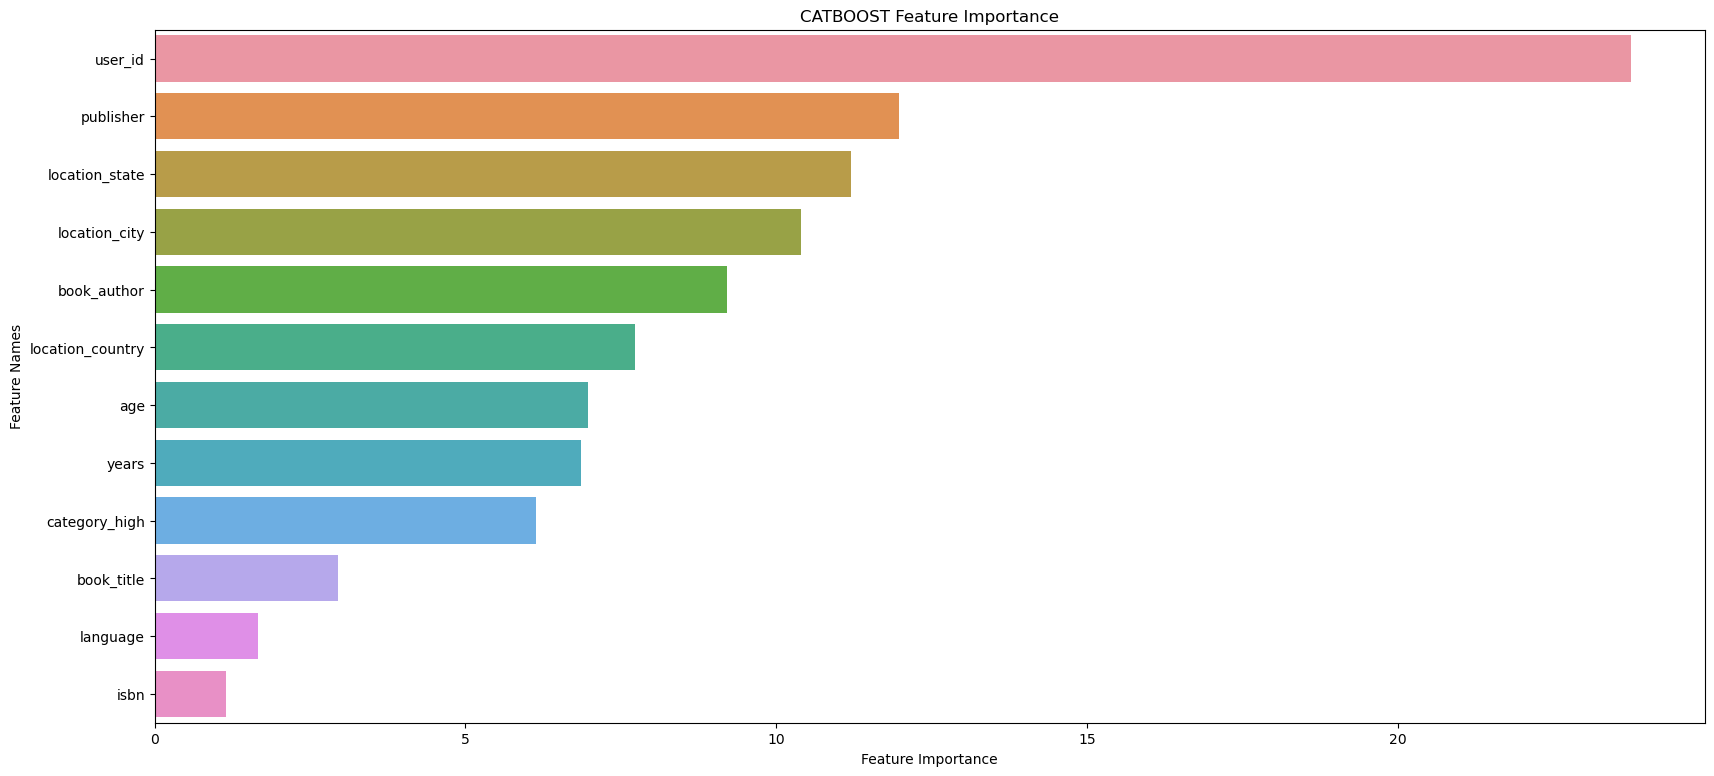

In [84]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(20,9))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    
    plt.show()


plot_feature_importance(model.get_feature_importance(), train_ratings.drop(['rating'],axis = 1).columns, 'CATBOOST')